A script for loading in tendencies (temperature or salinity) from FAFMIP experiments, with data available on NCI. These tendencies are then binned into watermass coordinates, with a focus on temperature-depth space, but the script should be easily adaptable to other coordinate systems (such as salinity-depth, temperature-latitude, salinity-latitude). I also want to feature a percentile option too.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc

# from dask.distributed import Client
# client = Client(n_workers=8)
# display(client)

In [3]:
path_fs38 = '/g/data/fs38/publications/CMIP6/FAFMIP/' # For ACCESS-CM2
path_oi10 = '/g/data/oi10/replicas/CMIP6/FAFMIP/'     # For models not ACCESS-CM2

In [77]:
def load_faf_expt_tendencies(model_name, faf_expt_name, variable_type):
    '''
    OPTIONS
    ---
    model_name:      'ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'FGOALS-g3', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M'
    faf_expt_name:   'faf-passiveheat', 'faf-heat', 'faf-all', 'faf-water', 'faf-stress'
    variable_type:   'temperature', 'salinity'
    ---
    '''
    
    ### Match model_name to modelling_group ###
    
    if model_name == 'ACCESS-CM2':
        modelling_group = 'CSIRO-ARCCSS'
    elif model_name == 'CAS-ESM2-0':
        modelling_group = 'CAS'
    elif model_name == 'CanESM5':
        modelling_group = 'CCCma'
    elif model_name == 'FGOALS-g3':
        modelling_group = 'CAS'
    elif model_name == 'MIROC6':
        modelling_group = 'MIROC'
    elif model_name == 'MPI-ESM1-2-HR':
        modelling_group = 'MPI-M'
    elif model_name == 'MRI-ESM2-0':
        modelling_group = 'MRI'
    elif model_name == 'CESM2':
        modelling_group = 'NCAR'
    elif model_name == 'GFDL-ESM2M':
        modelling_group = 'NOAA-GFDL'
    
    
    ### Define path to FAFMIP experiments ###
    
    if model_name == 'ACCESS-CM2':
        model_path = path_fs38 + modelling_group + '/' + model_name + '/'
    else:
        model_path = path_oi10 + modelling_group + '/' + model_name + '/'
        
    expt_path = model_path + faf_expt_name + '/*/'

    
    ### Get grid information ###
    
    # Area:
    try:
        if model_name == 'ACCESS-CM2':
            areacello = xr.open_mfdataset(expt_path + 'Ofx/areacello/gn/latest/*.nc')['areacello']
        else:
            areacello = xr.open_mfdataset(expt_path + 'Ofx/areacello/gn/*/*.nc')['areacello']
    except:
        areacello = np.empty(0)
        print('areacello for ' + model_name + ' not found')
    
    # Volume: 
    try:
        if model_name == 'ACCESS-CM2':
            volcello = xr.open_mfdataset(expt_path + 'Omon/volcello/gn/latest/*.nc')['volcello']
        else:
            volcello = xr.open_mfdataset(expt_path + 'Omon/volcello/gn/*/*.nc')['volcello']
            ### NB: Do I want to check if this is available in Ofx if not available at Omon????
            ### Answer: Yes, e.g. not currently available at Omon for CESM2 but is available at Ofx (presumably this is time-mean?)
    except:
        volcello = np.empty(0)
        print('volcello for ' + model_name + ' not found')
        
    
    ### Get available variables for the given model_name for the given variable_type ###
    
    variables = [] # List of budget variables to return at end of function.
    
    tendency_names = ['tend', 'rmadvect', 'padvect', 'psmadvect', 'pmdiff', 'diff']
    
    
    if variable_type == 'temperature':
        
        if model_name == 'ACCESS-CM2':
            temperature_type = 'ocontemp'
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/bigthetao/gn/latest/*.nc')['bigthetao']) # Temperature
            #variables.append(xr.open_mfdataset(expt_path + 'Omon/pabigthetao/gn/latest/*.nc')['pabigthetao']) # Added_temperature
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/latest/*.nc')[temperature_type + name]) # Tendency terms
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
            
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Omon/hfds/gn/latest/*.nc')['hfds']) # Net surface heat flux
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
                
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/latest/*.nc')['rsdoabsorb']) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
                
            
        else:
            temperature_type = 'opottemp'
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/thetao/gn/*/*.nc')['thetao'])
            #variables.append(xr.open_mfdataset(expt_path + 'Omon/pathetao/gn/*/*.nc')['pathetao'])
                    
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/*/*.nc')[temperature_type + name])
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
            
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Omon/hfds/gn/*/*.nc')['hfds']) # Net surface heat flux
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
                
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/*/*.nc')['rsdoabsorb']) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
    
    if variable_type == 'salinity':
        
        salinity_type = 'osalt'
        salinity = 'so'
        
        if model_name == 'ACCESS-CM2':
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/so/gn/latest/*.nc')['so'])
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/latest/*.nc')[salinity_type + name])
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            # Do: net surface water flux; try-except
        
        else:
            
            variables.append(xr.open_mfdataset(expt_path + 'Omon/so/gn/*/*.nc')['so'])
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/*/*.nc')[salinity_type + name])
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            # Do: net surface water flux; try-except
            
            
    return variables, areacello, volcello

### Temp-z streamfunction for ACCESS-CM2. 

Try for ACCESS-CM2 first. Then generalise to all models. Then generalise to difference coordinates. Then include percentiles.

In [74]:
ACCCESS_CM2_faf_passiveheat_temp = load_faf_expt_tendencies('ACCESS-CM2', 'faf-passiveheat', 'temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full nump

In [111]:
# Using the language of Abhi's 2021 SRC paper:

TEMP = ACCCESS_CM2_faf_passiveheat_temp[0][0] # Temperature field
TEND = ACCCESS_CM2_faf_passiveheat_temp[0][1] # Total tendency
ADV = ACCCESS_CM2_faf_passiveheat_temp[0][2]  # Tendency from residual mean advection 
MESO = ACCCESS_CM2_faf_passiveheat_temp[0][3] # Tendency from eddy advection
SUB = ACCCESS_CM2_faf_passiveheat_temp[0][4]  # Tendency from submesoscale advection
ISO = ACCCESS_CM2_faf_passiveheat_temp[0][5]  # Tendency from mesoscale diffusion
DIA = ACCCESS_CM2_faf_passiveheat_temp[0][6]  # Tendency from dianeautral mixing
SFC = ACCCESS_CM2_faf_passiveheat_temp[0][7]  # Net surface heat fluxx
SWP = ACCCESS_CM2_faf_passiveheat_temp[0][8]  # Shortwave absorption

area = ACCCESS_CM2_faf_passiveheat_temp[1]    # Area of grid cells
volume = ACCCESS_CM2_faf_passiveheat_temp[2]  # Volume of grid cells

In [119]:
TEMP.groupby('time.year').mean(dim='time')

<xarray.DataArray 'bigthetao' (year: 70, lev: 50, j: 300, i: 360)>
dask.array<stack, shape=(70, 50, 300, 360), dtype=float32, chunksize=(1, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * year       (year) int64 950 951 952 953 954 955 ... 1015 1016 1017 1018 1019

In [217]:
TEND

<xarray.DataArray 'ocontemptend' (time: 70, lev: 50, j: 300, i: 360)>
dask.array<open_dataset-4286d1bc9201164237c9ef685174d9faocontemptend, shape=(70, 50, 300, 360), dtype=float32, chunksize=(70, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 0950-07-02 12:00:00 ... 1019-07-02 12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 -77.88 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 80.5 81.5 82.5 83.5 ... 79.94 79.96 79.97 79.99
Attributes:
    standard_name:  tendency_of_sea_water_conservative_temperature_expressed_...
    long_name:      Tendency of Sea Water Conservative Temperature Expressed ...
    comment:        Tendency of heat content for a grid cell from all process...
    units:          W m-2
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2019-12-10T04:27:22Z altered by CMOR: replaced missing va...

In [123]:
TEMP_t0 = TEMP.isel(time=0).load()

2022-03-30 15:50:33,984 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.42 GiB -- Worker memory limit: 7.50 GiB
2022-03-30 15:50:34,081 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.59 GiB -- Worker memory limit: 7.50 GiB


In [155]:
TEMP_t0.max()

<xarray.DataArray 'bigthetao' ()>
array(31.9337101)
Coordinates:
    time     object 0950-01-16 12:00:00

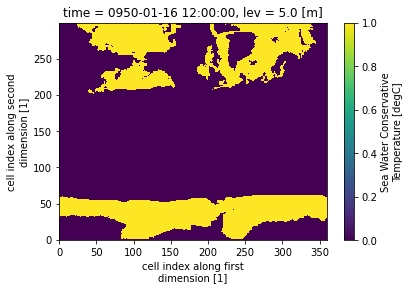

In [141]:
np.less(TEMP_t0.isel(lev=0), 10).plot()

In [149]:
TEND_t0 = TEND.isel(time=0).load()

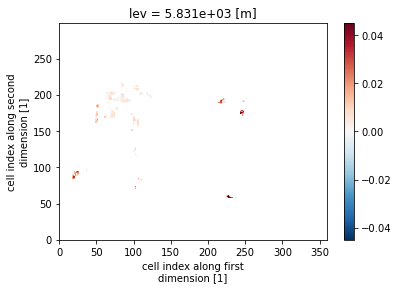

In [153]:
(TEND_t0.isel(lev=-1) * np.less(TEMP_t0.isel(lev=-1), 10)).plot()

In [203]:
TEND

<xarray.DataArray 'ocontemptend' (time: 70, lev: 50, j: 300, i: 360)>
dask.array<open_dataset-4286d1bc9201164237c9ef685174d9faocontemptend, shape=(70, 50, 300, 360), dtype=float32, chunksize=(70, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 0950-07-02 12:00:00 ... 1019-07-02 12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 -77.88 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 80.5 81.5 82.5 83.5 ... 79.94 79.96 79.97 79.99
Attributes:
    standard_name:  tendency_of_sea_water_conservative_temperature_expressed_...
    long_name:      Tendency of Sea Water Conservative Temperature Expressed ...
    comment:        Tendency of heat content for a grid cell from all process...
    units:          W m-2
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2019-12-10T04:27:22Z altered by CMOR: replaced missing va...

In [216]:
np.less(TEMP_t0, 10)

<xarray.DataArray 'bigthetao' (lev: 50, j: 300, i: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
    time       object 0950-01-16 12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 -77.88 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 80.5 81.5 82.5 83.5 ... 79.94 79.96 79.97 79.99
Attributes:
    standard_name:   sea_water_conservative_temperature
    long_name:       Sea Water Conservative Temperature
    comment:         Sea water conservative temperature (this should be contr...
    units:           degC
    original_units:  K
    history:         2019-12-10T04:22:58Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello volume: volcello

In [ ]:
def tendency_term_binning(tendency_term, coordinate, bin_size, coordinate_min, coordinate_max):
    '''
    OPTIONS
    ---
    coordinate:      either temperature or salinity, four-dimensional (time, depth, latitude, longitude) xarray DataArray
    tendency_term:   a four-dimensional (time, depth, latitude, longitude) xarray DataArray
    bin_size:        float (size of bin to be used to bin tendency_term into coordinate
    coordinate_min:  float (maximum of coordinate)
    coordinate_max:  float (minimum of coordinate)
    ---
    '''
    
    coordinate_bins = np.arange(coordinate_min, coordinate_max + bin_size, bin_size) # The edges of the bins of the new coordinate
    
    tendency_term_binned = np.empty(tendency_term.shape + coordinate_bins.shape) # tendency_term to be binned into the new coordinate
    
    for n in range(len(coordinate.time)):
        # Load in the values of coordinate at each time step as we need their values:
        values = coordinate.isel(time = n).load() 
        
        for index in range(len(coordinate_bins)):
            # This defines the tendency term in the new coordinate space
            tendency_term_binned[n, :, :, :, index] = np.less(values, coordinate_bins[index]) * tendency_term.isel(time = n)
            # np.less(values, blah) gives back a bool, which when multipled against an array returns 0 if False and 1 if True. Do I instead want np.nan if False and 1 if True?
            # Or does it not matter when this tendency_term_binned function is in an integral, thus 0 contributing nothing to the integral...
            
        
        
    return tendency_term_binned

In [ ]:
# def tendency_streamfunction()

In [10]:
def diagnostic_cal(var, t_s, t_s_range):
          
    var2_tempz_bin_temp = np.zeros((np.size(var,0), np.size(t_s_range), np.size(var,1)))
    
    for i in range(np.size(var,0)):
        
        for ii in range(np.size(var,1)):
                                   
            Tonz = np.squeeze(t_s[i, ii, :, :]) 
            ind = np.digitize(np.ravel(Tonz), t_s_range)
            
            var_tempz = np.squeeze(var[i, ii, :, :])
            totfre1 = np.bincount(np.ravel(ind), weights = np.ravel(var_tempz))
            var2_tempz_bin_temp[i, :, ii] = totfre1[1:]
            
        var2_bin = var2_tempz_bin_temp
        
    return var2_bin

In [12]:
delta_salt = 0.05
delta_temp = 0.5
rho = 1035
cp = 3992

# Why?:
x_salt = delta_salt
x_temp = rho * cp * delta_temp #

dz = st_ocean
temp_range = np.arange(-3, 35, delta_temp)
salt_range =  np.arange(0, 45, delta_salt)

In [ ]:
adv_bin = diagnostic_cal(ADV_temp, temp, temp_range)

In [24]:
def circulation_cal(var, x):
    
    ADV_mean_mean = np.nanmean(var, axis = 0)
    ADV_mean_new = np.squeeze(ADV_mean_mean)
    cumdPSi_temp_mean = (np.cumsum(ADV_mean_new, 1))

    cumdPSi_temp_mean_dz = np.transpose(np.matlib.repmat(cumdPSi_temp_mean[:,-1], np.size(var, 2), 1)) - cumdPSi_temp_mean
    cumdPSi_temp_mean_m3 = cumdPSi_temp_mean_dz / x
    cumdPSi_temp_mean_SV = cumdPSi_temp_mean_m3 * 1e-6
    
    return cumdPSi_temp_mean_SV

In [3]:
ds = xr.open_mfdataset(path + 'ocean.nc')
ds_area = xr.open_mfdataset(path + 'ocean_grid.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
st_ocean = ds.st_ocean
time = ds.time
area_t = ds_area.area_t

In [5]:
temp_advection = ds.temp_advection * area_t
temp_vdiffuse_impl = ds.temp_vdiffuse_impl* area_t
temp_vdiffuse_diff_cbt_conv = ds.temp_vdiffuse_diff_cbt_conv* area_t
temp_nonlocal_kpp = ds.temp_nonlocal_KPP* area_t
neutral_gm_temp = ds.neutral_gm_temp* area_t
neutral_diffusion_temp = ds.neutral_diffusion_temp* area_t
temp_submeso =ds.temp_submeso* area_t
mixdownslope_temp = ds.mixdownslope_temp* area_t
sw_heat = ds.sw_heat* area_t
sfc_hflux_pme = ds.sfc_hflux_pme* area_t
temp_rivermix = ds.temp_rivermix* area_t
frazil_3d = ds.frazil_3d* area_t
temp_tendency = ds.temp_tendency* area_t
temp_vdiffuse_sbc = ds.temp_vdiffuse_sbc* area_t

temp = ds.temp-273.15

In [6]:
ADV_temp = temp_advection                                                     # % Advection;                                   % UNit = W/m^2
DIA_temp = temp_vdiffuse_impl - temp_vdiffuse_diff_cbt_conv                     # % Dianeutral diffusion or vertical dissusion;  % UNit = W/m^2
KPP_temp = temp_nonlocal_kpp                                                  # % non-local KPP;                               % UNit = W/m^2
EIT_temp = neutral_gm_temp + neutral_diffusion_temp                             # % Eddy-induced transport;                      % Unit =W/m^2
EIT_ADV_temp = neutral_gm_temp                                                # % Eddy-induced advection transport;            % Unit =W/m^2
SUB_temp = temp_submeso                                                       # % Submesoscale eddies;                         % UNit = W/m^2
CON_temp = temp_vdiffuse_diff_cbt_conv+mixdownslope_temp                      # % Convection;                                  % UNit = W/m^2
SWP_temp = sw_heat                                                            # % Shortwave penetration;                       % Unit = W/m^2
PME_temp = sfc_hflux_pme                                                      # % Precipitation minis evaporation;             % Unit =W/m^2
RIV_temp = temp_rivermix                                                      # % River runnoff;                               % UNit = W/m^2
FRZ_temp = frazil_3d                                                          # % Frazil;                                      % Unit = W/m^2
NET_temp = temp_tendency                                                      # % Frazil;                                      % Unit = W/m^2

In [ ]:
ADV_temp

<xarray.DataArray (time: 20, st_ocean: 50, yt_ocean: 300, xt_ocean: 360)>
dask.array<mul, shape=(20, 50, 300, 360), dtype=float32, chunksize=(20, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 2920-07-02 12:00:00 ... 2939-07-02 12:00:00
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>